In [1]:
import scanpy as sc
import numpy as np
import os
# Set reproducibility seed (used later in PCA, UMAP, clustering)
np.random.seed(42)

In [2]:
# Set where figures will be saved
sc.settings.figdir = "../results/figures"
os.makedirs(sc.settings.figdir, exist_ok=True)

In [3]:
# Set where figures will be saved
sc.settings.figdir = "../results/figures"
os.makedirs(sc.settings.figdir, exist_ok=True)

In [5]:
# Step 1:Load preprocessed object (after QC and doublet removal)
adata = sc.read_h5ad("../results/anndata/qc_nodoublets.h5ad")

In [6]:
#Step 2:Normalize Total Counts
sc.pp.normalize_total(adata, target_sum=1e4)

We normalize library size to make total counts per cell equal (default 10,000)
It removes bias	and eliminates differences due to sequencing depth. Without this, comparisons across cells are unreliable

In [7]:
#Step 3:Log1p Transformation
sc.pp.log1p(adata)

Log transform applies log(x + 1) to normalized counts and stabilizes variance. This reduces the impact of highly expressed genes
PCA and clustering perform better on log-scaled data

In [8]:
#Step4: Store .raw Expression Matrix
adata.raw = adata
#Captures the log-normalized data before HVG filtering
#Later visualizations (UMAP coloring, violin plots)

In [9]:
#Step 5: Identify Highly Variable Genes (HVGs)
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)

***Feature Selection***: Finds genes with high biological (not technical) variability. Filters out too-rare or too-common genes

In [11]:
#Inspect selected genes:
adata.var[adata.var["highly_variable"]].head(20)

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
PLEKHN1,False,False,811,0.012691,98.819677,872,811,True,0.086196,2.551479,0.538397
ISG15,False,False,1013,0.018804,98.525688,1292,1013,True,0.083189,2.631112,0.831472
TNFRSF18,False,False,212,0.003435,99.691457,236,212,True,0.032508,2.677337,1.001597
TNFRSF4,False,False,201,0.003129,99.707466,215,201,True,0.028183,2.666930,0.963296
CFAP74,False,False,777,0.016693,98.869160,1147,777,True,0.078289,2.568793,0.602118
AL590822.1,False,False,173,0.002634,99.748217,181,173,True,0.019456,2.570645,0.608934
PLCH2,False,False,327,0.005021,99.524087,345,327,True,0.043722,2.622471,0.799671
AL139246.5,False,False,212,0.003129,99.691457,215,212,True,0.023133,2.557925,0.562122
TTC34,False,False,1012,0.028948,98.527143,1989,1012,True,0.118859,2.615051,0.772363
PRDM16,False,False,5450,0.112968,92.068112,7762,5450,True,0.519616,2.771013,0.768640


In [12]:
# See how many HVGs were selected
adata.var["highly_variable"].sum()

np.int64(3894)

saving figure to file ..\results\figures\filter_genes_dispersion_hvg_selection.png


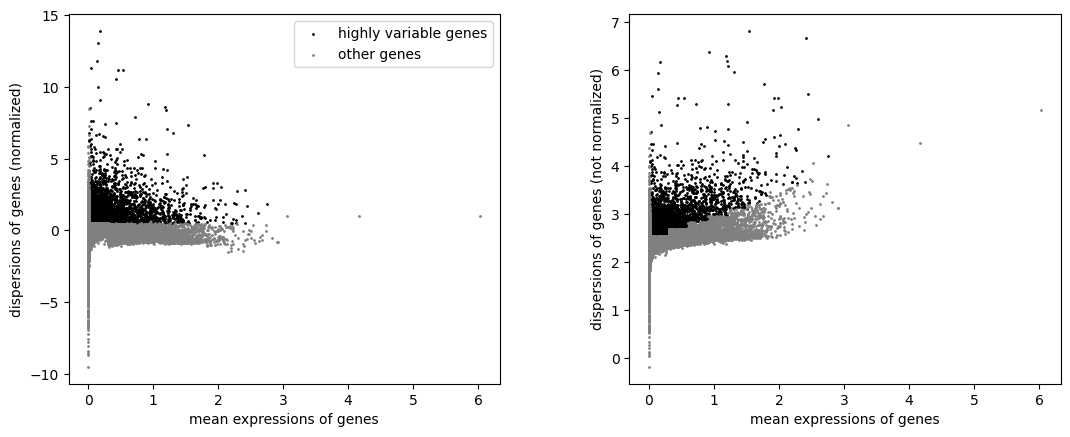

In [14]:
# Step 6: Plot HVGs
sc.pl.highly_variable_genes(adata, save="_hvg_selection.png")

In [ ]:
HVG dispersion plotwas generated, which shows how genes vary by expression level.
The left panel (normalized dispersion vs. mean) is used to select HVGs — black dots are retained genes, grey are filtered out.
The right panel shows unnormalized dispersion for reference — it's skewed and not used for filtering.
This confirms you've successfully selected biologically informative genes for PCA and clustering.

In [15]:
#Step 7.Filter to HVGs Only
adata = adata[:, adata.var["highly_variable"]]
#Reduce feature and keeps only HVGs.Makes PCA & clustering faster and more stable

In [16]:
#Step 8: Save the Filtered Object for PCA & Clustering
adata.write("../results/anndata/normalized_hvg.h5ad")

In [17]:
adata.shape  # (n_cells, n_HVGs)

(65217, 3894)

In [18]:
adata.obs.head()

,sample,condition,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,doublet_score,predicted_doublet
TAGGTACCATGGCCAC-1_1,GSM5226574_C51ctr,Control,6764,24256,153,0.630772,78,0.321570,6764,0.020862,False
ATTCACTGTAACAGGC-1_1,GSM5226574_C51ctr,Control,6686,19020,404,2.124080,137,0.720294,6686,0.148958,False
TAACTTCCAACCACGC-1_1,GSM5226574_C51ctr,Control,5158,15645,221,1.412592,231,1.476510,5158,0.085392,False
TTGGGTACACGACAAG-1_1,GSM5226574_C51ctr,Control,4900,15220,3,0.019711,10,0.065703,4900,0.013437,False
AGGCCACAGAGTCACG-1_1,GSM5226574_C51ctr,Control,5544,13217,417,3.155028,96,0.726337,5544,0.129433,False


In [19]:
#Step 9: Scale the Data
sc.pp.scale(adata, max_value=10)
#Standardizes the expression values of each gene across all cells

C:\Users\nn\.conda\envs\scrna-env\lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
#Step 10: Principal Component Analysis (PCA)
sc.tl.pca(adata, svd_solver="arpack", random_state=42)
#Dimensionality reduction,captures global structure and denoises the data. "arpack"	Good for large/sparse matrices

saving figure to file ..\results\figures\pca_variance_ratio_pca_variance.png


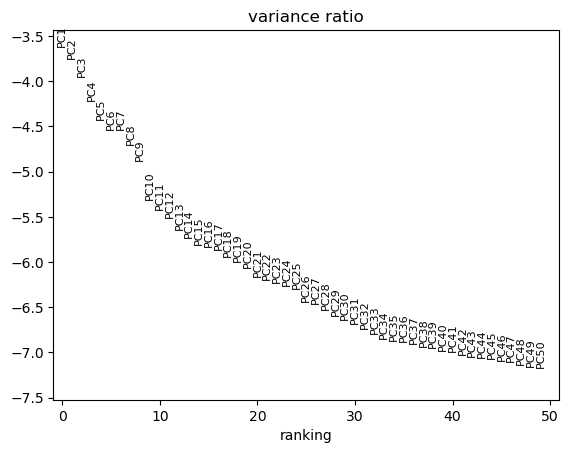

In [21]:
#Step 11: Scree Plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save="_pca_variance.png")
#Scree plot shows how much variance each PC explains

In [22]:
#Step 12: Compute Nearest Neighbor Graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=42)
#Builds a k-NN graph and each cell is connected to its 10 nearest neighbors (in PCA space)

C:\Users\nn\.conda\envs\scrna-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
#Step 13 — Leiden Clustering
sc.tl.leiden(adata, resolution=0.5, random_state=42)
#Leiden Clustering groups similar cells into distinct clusters based on the k-NN graph.
#It assigns each cell a cluster ID (adata.obs["leiden"]), 
#Reveals cell populations for downstream analysis like UMAP, annotation, and marker detection.

C:\Users\nn\AppData\Local\Temp\ipykernel_9944\257586868.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, random_state=42)


saving figure to file ..\results\figures\umap_clusters.png


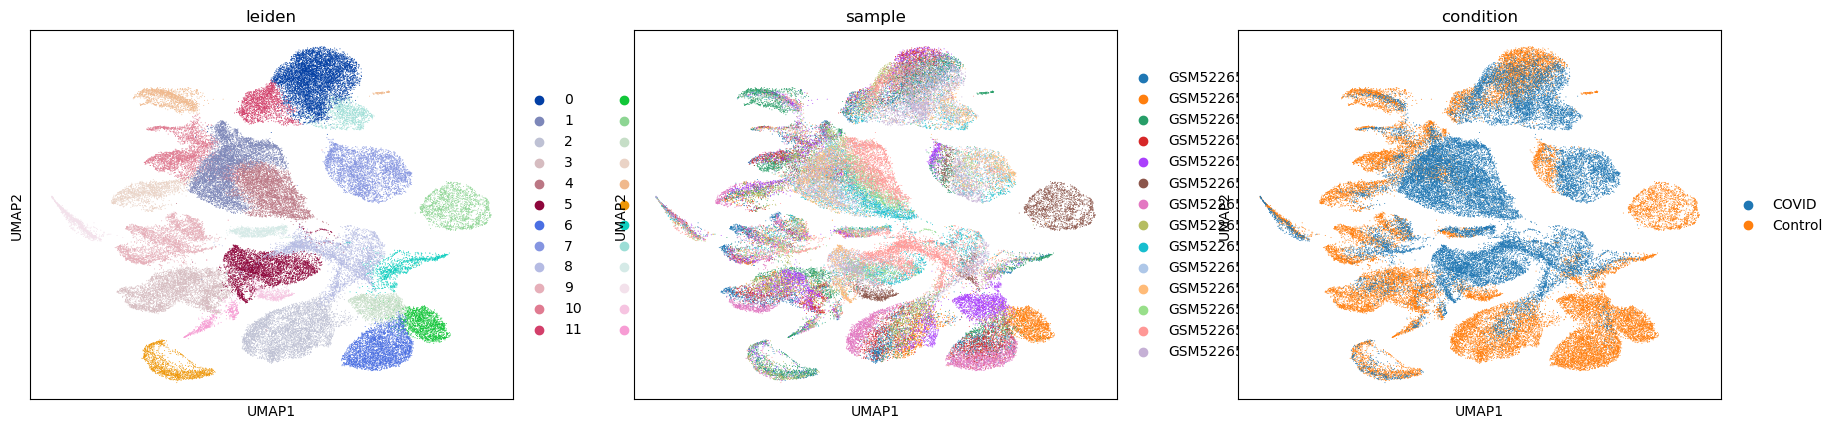

In [24]:
#Step 14: UMAP Visualization
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color=["leiden", "sample", "condition"], save="_clusters.png")
#Computes a 2D layout for visualization and plots clusters and metadata in UMAP space

In [26]:
print(adata.obs.columns.tolist())

['sample', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden']


In [27]:
#Log-Transformed Versions for Better Visualization
adata.obs["log1p_total_counts"] = np.log1p(adata.obs["total_counts"])
adata.obs["log1p_n_genes_by_counts"] = np.log1p(adata.obs["n_genes_by_counts"])

saving figure to file ..\results\figures\umap_qc_panels.png


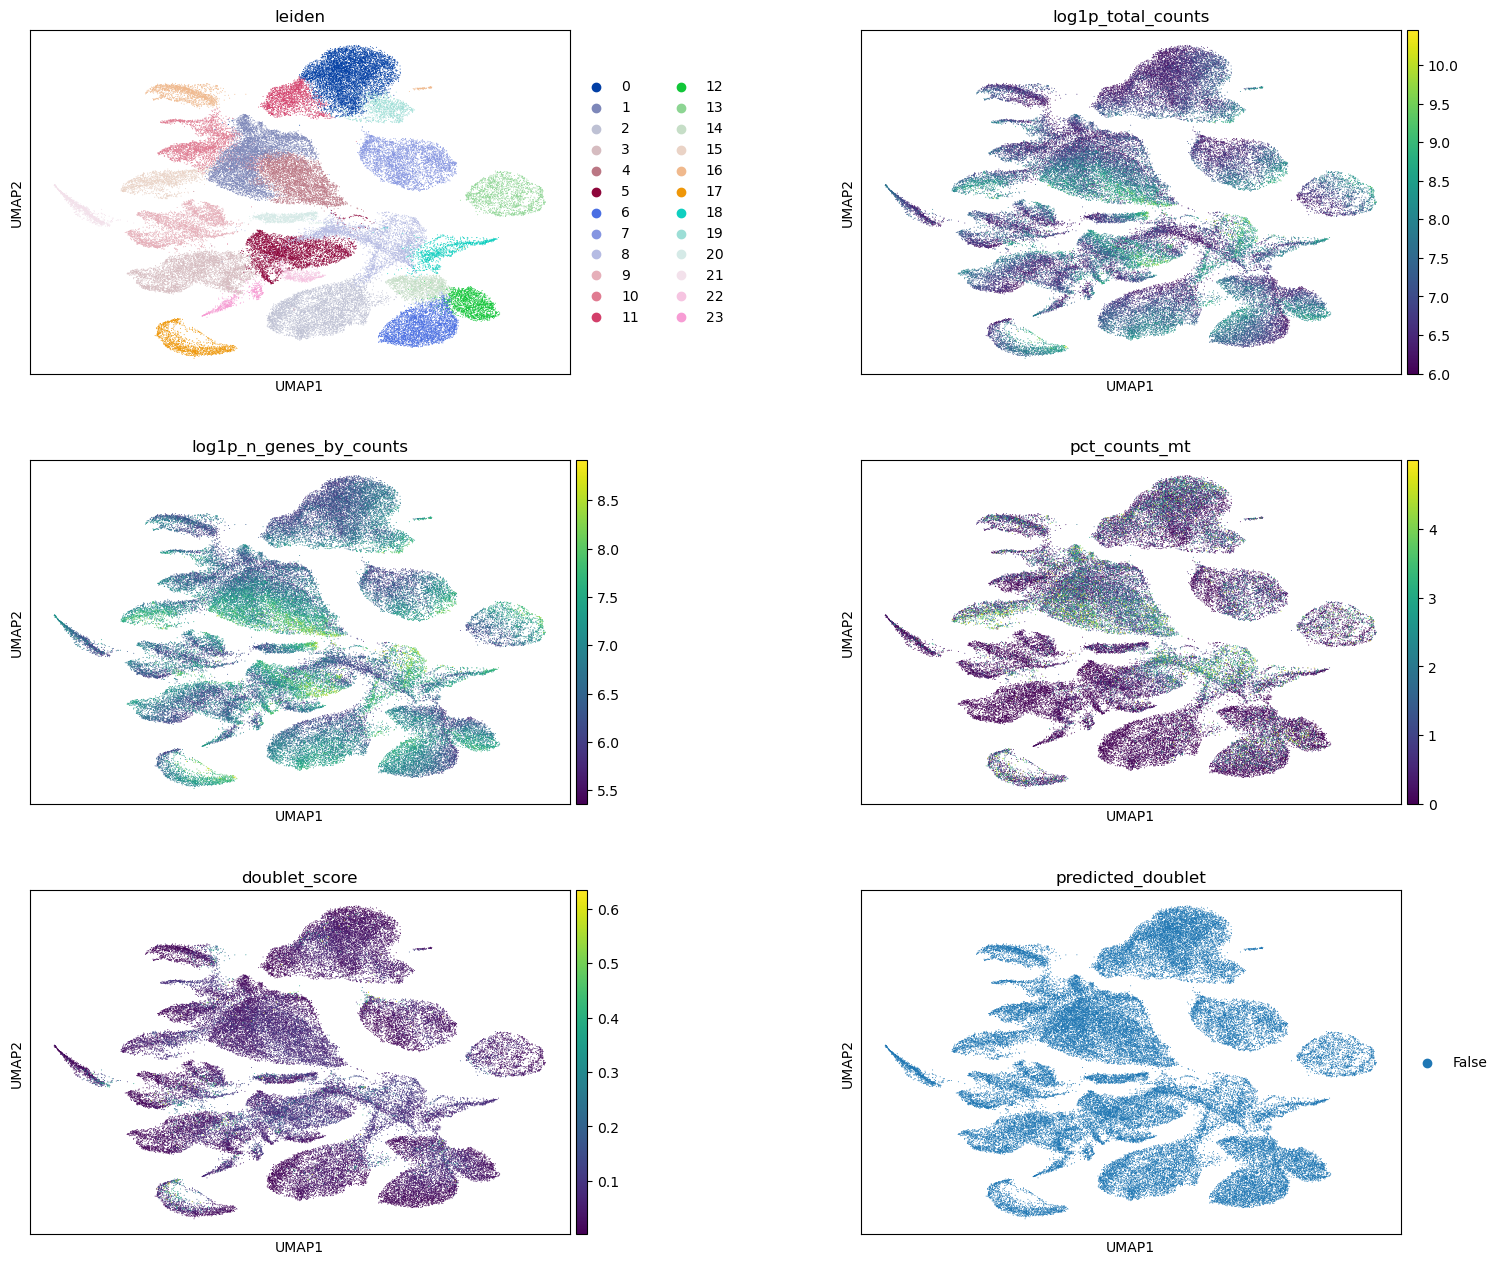

In [30]:
#Additional UMAP Panels. UMAP plots for batch effect checks:
sc.pl.umap(
    adata,
    color=[
        "leiden",
        "log1p_total_counts",
        "log1p_n_genes_by_counts",
        "pct_counts_mt",
        "doublet_score",
        "predicted_doublet"
    ],
    wspace=0.4,
    ncols=2,
    save="_qc_panels.png"
)

In [29]:
adata.write("../results/anndata/clustered.h5ad")

In [ ]:
🔹 Step 15 — Save Final Object
python
Copy
Edit
adata.write("../results/anndata/clustered.h5ad")
File	What It Contains
clustered.h5ad	Full analysis object: PCA, clusters, UMAP, etc.

✅ Optional Git Commit After Completion:
bash
Copy
Edit
git add notebooks/02_preprocessing_and_clustering.ipynb \
         results/anndata/clustered.h5ad \
         results/figures/pca_variance_pca_variance.png \
         results/figures/umap_clusters.png

git commit -m "Completed PCA, clustering, and UMAP embedding"
git push origin main